[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dgomes03/FIRE-HACK-Project/blob/main/RFR_model.ipynb)

In [1]:
import os
import math
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
from dbfread import DBF
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy import stats
from scipy.stats import randint, uniform, gaussian_kde
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    TimeSeriesSplit,
    KFold,
    HalvingRandomSearchCV,
)
from sklearn.experimental import enable_halving_search_cv 
from sklearn.inspection import PartialDependenceDisplay
import xgboost as xgb
import shap
import pickle
import shap

### Load data

In [2]:
print("Loading dataset...")

try:
    shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp'
    df = gpd.read_file(shp_path)
    print("Dataset loaded")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Loading dataset...
Dataset loaded


c:\Users\dias3\miniconda3\envs\geoenv\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


### Remove nans from ros_p

In [3]:
n_before = len(df)
df = df.dropna(subset=['ros_p'])
n_after = len(df)
print(f"Removed {n_before - n_after} rows with NaN in 'ros_p'. Remaining rows: {n_after}")

Removed 0 rows with NaN in 'ros_p'. Remaining rows: 1173


### Convert categorical variables into "category" type

In [4]:
c = ["fuel_model", "landform", "land_use", "Haines_av"]

for col in c:
     df[col] = df[col].astype(str).astype('category')

### Select specific columns for modeling
These variables were chosen because they have the highest |SHAP| values, being considered the most important for modeling.

In [5]:
df.drop(columns=['ros_p_lg1', 'inidoy', 'enddoy'], inplace=True)

for col in df.columns:
    print(col)

ros_p
duration_p
elev_av
aspect_av
landform
land_use
1_3y_fir_p
3_8y_fir_p
8_ny_fir_p
fuel_model
f_load_av
sW_1m_av
sW_3m_av
sW_7_av
sW_28_av
sW_100_av
sW_289_av
t_2m_C_av
d_2m_C_av
rh_2m_av
VPD_Pa_av
sP_hPa_av
gp_m2s2_av
dfmc_av
HDW_av
Haines_av
FWI_12h_av
DC_12h_av
FFMC_12h_a
wv10_kh_av
wdir10_av
wv100_k_av
wdir100_av
Recirc
CircVar
t_950_av
t_850_av
t_700_av
t_500_av
t_300_av
rh_950_av
rh_850_av
rh_700_av
rh_500_av
rh_300_av
wv_950_av
wv_850_av
wv_700_av
wv_500_av
wv_300_av
wdi_950_av
wdi_850_av
wdi_700_av
wdi_500_av
wdi_300_av
vwv_950_av
vwv_850_av
vwv_700_av
vwv_500_av
vwv_300_av
gp_950_av
gp_850_av
gp_700_av
gp_500_av
gp_300_av
gT_s_9_av
gT_9_8_av
gT_8_7_av
gT_7_5_av
gT_5_3_av
wSv_9_av
wSdir_9_av
wSv_7_av
wSdir_7_av
wSv_5_av
wSdir_5_av
wSv_1_av
wSdir_1_av
CBH_m_av
HigCC_p_av
LowCC_p_av
MidCC_p_av
TotCC_p_av
Cape_av
Cin_av
BLH_m_av
BLH_m_rt
LCL_hPa_av
LCL_m_av
LFC_hPa_av
CCL_hPa_av
EL_m_av
LiftIdx_av
VentIdx_av
CMLG_av
f_start
geometry


### Create test and train datasets

In [6]:
train_features = [col for col in df.columns if col not in ('ros_p', "geometry", 'row_id')]

X = df[train_features]
y_raw = df['ros_p']

# Safe signed log
y = np.sign(y_raw) * np.log1p(np.abs(y_raw))

print(len(y))

1173


### XGBoost Model
This model first uses a KFold approach for Cross-Validation in order to find the best hyperparameters for the XGBoost model. Then, it applies these hyperparameters to train the final model which is trained on 100% of the dataset The "Best Cross-Validation Score (R2)" score given is the average R2 of the Cross Validation process, not the R2 from the final model, since there is not test dataset.

In [7]:
import numpy as np
import pandas as pd
import pickle
from scipy.stats import uniform, randint
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

# =============================
# Features e target
# =============================
train_features = [col for col in df.columns if col not in ('ros_p', "geometry", 'row_id')]
X = df[train_features]
y_raw = df['ros_p']

# Safe signed log
y = np.sign(y_raw) * np.log1p(np.abs(y_raw))

from scipy.stats import uniform, randint

# =============================
# Hiperparâmetros ajustados para maior complexidade
# =============================
from scipy.stats import uniform, randint

param_dist = {
    'max_depth': [5, 6, 7],                       # árvores moderadamente profundas
    'learning_rate': uniform(0.05, 0.10),        # aprendizado lento
    'subsample': uniform(0.6, 0.3),              # mais amostras por árvore, controlado
    'colsample_bytree': uniform(0.6, 0.3),       # mais colunas por árvore
    'colsample_bylevel': uniform(0.6, 0.3),
    'colsample_bynode': uniform(0.6, 0.3),
    'min_child_weight': randint(12, 40),         # folhas menores, mas não extremas
    'gamma': uniform(0.5, 1.5),                  # divisões moderadas
    'reg_alpha': uniform(0.5, 2.0),              # regularização L1 equilibrada
    'reg_lambda': uniform(2.5, 3.5),             # regularização L2 equilibrada
    'max_delta_step': randint(0, 5),             # sem mudança
}



# =============================
# Modelo base
# =============================
base_model = xgb.XGBRegressor(
    n_jobs=-1,
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',
    enable_categorical=True
)

# =============================
# 1️⃣ Busca de hiperparâmetros com K-Fold
# =============================
kf_search = KFold(n_splits=5, shuffle=True, random_state=42)

xgb_search = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=2,
    resource='n_estimators',
    max_resources=500,
    min_resources=20,
    scoring='r2',
    cv=kf_search,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

xgb_search.fit(X, y)
best_model = xgb_search.best_estimator_

print(f"Best params: {xgb_search.best_params_}")
print(f"Best CV R² during search: {xgb_search.best_score_:.4f}")

# =============================
# 2️⃣ Avaliação com Repeated K-Fold
# =============================
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# Função inversa do safe log
def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

# Arrays para armazenar métricas
r2_list_log = []
mae_list_log = []
rmse_list_log = []

r2_list_orig = []
mae_list_orig = []
rmse_list_orig = []

# Loop manual sobre os folds
for train_idx, test_idx in rkf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    # Treina modelo no fold
    model_fold = best_model.fit(X_train_fold, y_train_fold)
    y_pred_log = model_fold.predict(X_test_fold)

    # Métricas log
    r2_list_log.append(r2_score(y_test_fold, y_pred_log))
    mae_list_log.append(mean_absolute_error(y_test_fold, y_pred_log))
    rmse_list_log.append(np.sqrt(mean_squared_error(y_test_fold, y_pred_log)))

    # Métricas original
    y_pred_orig = inverse_safe_log(y_pred_log)
    y_test_orig = inverse_safe_log(y_test_fold)
    mae_list_orig.append(mean_absolute_error(y_test_orig, y_pred_orig))
    rmse_list_orig.append(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)))


# Resultados médios
print("\n=== Métricas no log-transformado (RepeatedKFold) ===")
print(f"R²: {np.mean(r2_list_log):.4f} ± {np.std(r2_list_log):.4f}")
print(f"MAE: {np.mean(mae_list_log):.4f} ± {np.std(mae_list_log):.4f}")
print(f"RMSE: {np.mean(rmse_list_log):.4f} ± {np.std(rmse_list_log):.4f}")

print("\n=== Métricas no espaço original (ros_p) ===")
print(f"MAE: {np.mean(mae_list_orig):.4f} ± {np.std(mae_list_orig):.4f}")
print(f"RMSE: {np.mean(rmse_list_orig):.4f} ± {np.std(rmse_list_orig):.4f}")

# =============================
# Treinar modelo final no dataset completo
# =============================
final_model = best_model.fit(X, y)


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 20
max_resources_: 500
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 25
n_resources: 20
Fitting 5 folds for each of 25 candidates, totalling 125 fits


----------
iter: 1
n_candidates: 13
n_resources: 40
Fitting 5 folds for each of 13 candidates, totalling 65 fits
----------
iter: 2
n_candidates: 7
n_resources: 80
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 3
n_candidates: 4
n_resources: 160
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 320
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params: {'colsample_bylevel': 0.6434684616273669, 'colsample_bynode': 0.7468358280832689, 'colsample_bytree': 0.8956951362331802, 'gamma': 0.8630829072672506, 'learning_rate': 0.11721355474058787, 'max_delta_step': 2, 'max_depth': 7, 'min_child_weight': 28, 'reg_alpha': 1.9564326972237192, 'reg_lambda': 3.7872409645173866, 'subsample': 0.7896917491780738, 'n_estimators': 320}
Best CV R² during search: 0.6268

=== Métricas no log-transformado (RepeatedKFold) ===
R²: 0.6146 ± 0.0419
MAE: 0.5250 ± 0.0254
RMSE: 0.6724 ± 0.0325

=== Métricas no e

In [8]:
import shap
import pandas as pd

# =============================
# Criar explainer SHAP
# =============================
explainer = shap.TreeExplainer(final_model)

# =============================
# Calcular valores SHAP
# =============================
shap_values = explainer.shap_values(X)

# =============================
# Calcular importância média absoluta
# =============================
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(shap_values).mean(axis=0)
})

# Ordenar por importância decrescente
shap_importance = shap_importance.sort_values(by='importance', ascending=False)

# Mostrar top 20
print(shap_importance.head(20))


       feature  importance
0   duration_p    0.315143
7   8_ny_fir_p    0.093978
14   sW_100_av    0.092262
6   3_8y_fir_p    0.091972
94     f_start    0.088871
23      HDW_av    0.082212
9    f_load_av    0.068350
25  FWI_12h_av    0.068041
30  wv100_k_av    0.062516
66   gT_8_7_av    0.053806
75    wSv_1_av    0.038763
5   1_3y_fir_p    0.035328
11    sW_3m_av    0.035118
3     landform    0.031230
45   wv_850_av    0.030912
2    aspect_av    0.029460
10    sW_1m_av    0.029180
12     sW_7_av    0.025149
36    t_700_av    0.021509
26   DC_12h_av    0.021204


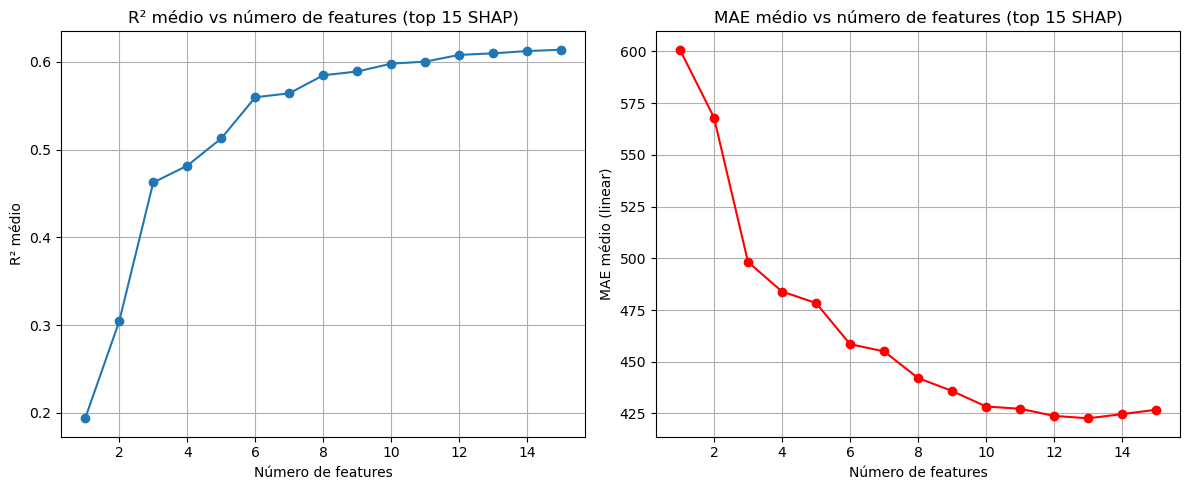

In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import xgboost as xgb

# =============================
# Função inversa do safe log
# =============================
def inverse_safe_log(y_log):
    """Converte valores log transformados de volta para a escala original."""
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

# =============================
# Seleção das top 15 features pelo SHAP
# =============================
top_features = shap_importance['feature'].tolist()[:15]

# Arrays para armazenar métricas
r2_scores = []
mae_scores_linear = []

# RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# Loop progressivo adicionando features
for i in range(1, len(top_features)+1):
    selected_features = top_features[:i]
    X_subset = X[selected_features]
    
    r2_list = []
    mae_linear_list = []
    
    # RepeatedKFold
    for train_idx, test_idx in rkf.split(X_subset):
        X_train, X_test = X_subset.iloc[train_idx], X_subset.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Treina modelo com os melhores hiperparâmetros
        model = xgb.XGBRegressor(**best_model.get_params())
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Métricas
        r2_list.append(r2_score(y_test, y_pred))
        
        # MAE linear: converter log → linear
        mae_linear_list.append(mean_absolute_error(
            inverse_safe_log(y_test),
            inverse_safe_log(y_pred)
        ))
    
    # Média das métricas
    r2_scores.append(np.mean(r2_list))
    mae_scores_linear.append(np.mean(mae_linear_list))

# =============================
# Plot R² e MAE linear
# =============================
plt.figure(figsize=(12,5))

# R² médio vs número de features
plt.subplot(1,2,1)
plt.plot(range(1, len(top_features)+1), r2_scores, marker='o')
plt.xlabel("Número de features")
plt.ylabel("R² médio")
plt.title("R² médio vs número de features (top 15 SHAP)")
plt.grid(True)

# MAE linear médio vs número de features
plt.subplot(1,2,2)
plt.plot(range(1, len(top_features)+1), mae_scores_linear, marker='o', color='red')
plt.xlabel("Número de features")
plt.ylabel("MAE médio (linear)")
plt.title("MAE médio vs número de features (top 15 SHAP)")
plt.grid(True)

plt.tight_layout()
plt.show()


In [10]:
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# =============================
# Seleção das top N features pelo SHAP
# =============================
n_features = 6
selected_features = shap_importance['feature'].tolist()[:n_features]

X_selected = X[selected_features]
n_samples = len(X_selected)

print(f"Usando as {n_features} features mais importantes: {selected_features}")

# =============================
# RepeatedKFold + média por amostra
# =============================
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

y_pred_sum = np.zeros(n_samples)
y_pred_count = np.zeros(n_samples)
y_test_sum  = np.zeros(n_samples)
y_test_count = np.zeros(n_samples)

r2_train_folds = []
r2_test_folds = []
mae_list = []
rmse_list = []

for train_idx, test_idx in rkf.split(X_selected):

    X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Treinar modelo do zero para este fold
    model = xgb.XGBRegressor(**best_model.get_params())
    model.fit(X_train, y_train)
    
    # Previsões
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Acumular previsões médias por amostra
    y_pred_sum[test_idx] += y_pred_test
    y_pred_count[test_idx] += 1
    y_test_sum[test_idx] += y_test.values
    y_test_count[test_idx] += 1
    
    # Métricas por fold
    r2_train_folds.append(r2_score(y_train, y_pred_train))
    r2_test_folds.append(r2_score(y_test, y_pred_test))
    mae_list.append(mean_absolute_error(y_test, y_pred_test))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))

# =============================
# Resultados finais com ± std
# =============================
r2_train_cv = np.mean(r2_train_folds)
r2_train_std = np.std(r2_train_folds)

r2_test_cv  = np.mean(r2_test_folds)
r2_test_std = np.std(r2_test_folds)

r2_gap_cv = r2_train_cv - r2_test_cv
r2_gap_std = np.sqrt(r2_train_std**2 + r2_test_std**2)  # propagação de erros

avg_pred_log = y_pred_sum / y_pred_count
avg_actual_log = y_test_sum / y_test_count

print("\n=== Desempenho do modelo final (log-transformado) ===")
print(f"R² treino médio: {r2_train_cv:.4f} ± {r2_train_std:.4f}")
print(f"R² teste  médio: {r2_test_cv:.4f} ± {r2_test_std:.4f}")
print(f"R² gap (treino − teste): {r2_gap_cv:.4f} ± {r2_gap_std:.4f}")
print(f"MAE médio: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"RMSE médio: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")

# =============================
# Treinar modelo final completo
# =============================
final_model_selected = xgb.XGBRegressor(**best_model.get_params())
final_model_selected.fit(X_selected, y)

model_path = f"../../Data/Models/model_xgboost.pkl"
with open(model_path, "wb") as f:
    pickle.dump(final_model_selected, f)

print(f"Modelo final salvo como {model_path}")
print("\n✓ Média de previsões por amostra gerada com sucesso.")


Usando as 6 features mais importantes: ['duration_p', '8_ny_fir_p', 'sW_100_av', '3_8y_fir_p', 'f_start', 'HDW_av']



=== Desempenho do modelo final (log-transformado) ===
R² treino médio: 0.7111 ± 0.0085
R² teste  médio: 0.5565 ± 0.0463
R² gap (treino − teste): 0.1546 ± 0.0471
MAE médio: 0.5693 ± 0.0350
RMSE médio: 0.7211 ± 0.0354
Modelo final salvo como ../../Data/Models/model_xgboost.pkl

✓ Média de previsões por amostra gerada com sucesso.


In [11]:
# ============================================================
# SHAP + PREDIÇÕES MÉDIAS + MERGE COM GEOFILE ORIGINAL
# ============================================================

import numpy as np
import pandas as pd
import geopandas as gpd
import shap
from sklearn.model_selection import RepeatedKFold
from tqdm import tqdm

# ------------------------------------------------------------
# 0. Parâmetros
# ------------------------------------------------------------
n_splits = 5
n_repeats = 4
threshold = 35   # 35% erro absoluto
shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp'
output_base = "../../Data/Models\PT_FireProg_model_SHAP_xgboost"

# df: GeoDataFrame original completo
gdf = gpd.read_file(shp_path).reset_index(drop=True)

# Top N features
selected_features = shap_importance['feature'].tolist()[:n_features]
gdf_valid = gdf.loc[df.index].reset_index(drop=True)  # mantém apenas índices de df
X_selected = gdf_valid[selected_features].copy()
y_selected = y.reset_index(drop=True)

n_samples = len(X_selected)

# DataFrame para armazenar resultados (com os mesmos nomes do segundo script)
shap_results = pd.DataFrame(index=X_selected.index, columns=[
    'ros_p_log','ros_p_linear','PredROS_log','PredROS_linear',
    'PredDiff','Err_pct','Error_p_abs','bad_pred'
])

# SHAP values com os mesmos nomes do segundo script
shap_values_all = pd.DataFrame(index=X_selected.index, columns=[f'{f}' for f in selected_features])

# Vetores para médias
y_pred_sum = np.zeros(n_samples)
y_pred_count = np.zeros(n_samples)
y_test_sum = np.zeros(n_samples)
y_test_count = np.zeros(n_samples)

# ------------------------------------------------------------
# 1. Repeated CV para previsões médias
# ------------------------------------------------------------
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
print("🔄 Calculando PredROS médias por Repeated CV...")

for train_idx, test_idx in tqdm(rkf.split(X_selected), total=n_splits*n_repeats):
    X_test = X_selected.iloc[test_idx]
    y_test_fold = y_selected.iloc[test_idx]
    
    # Previsão usando modelo final treinado
    y_pred = final_model_selected.predict(X_test)
    
    # Acumular médias
    y_pred_sum[test_idx] += y_pred
    y_pred_count[test_idx] += 1
    y_test_sum[test_idx] += y_test_fold.values
    y_test_count[test_idx] += 1

# ------------------------------------------------------------
# 2. Médias por amostra
# ------------------------------------------------------------
avg_pred_log = y_pred_sum / y_pred_count
avg_actual_log = y_test_sum / y_test_count

shap_results['PredROS_log'] = avg_pred_log
shap_results['ros_p_log'] = avg_actual_log

# Função inverse log seguro
def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

shap_results['PredROS_linear'] = inverse_safe_log(avg_pred_log)
shap_results['ros_p_linear'] = inverse_safe_log(avg_actual_log)

shap_results['PredDiff'] = shap_results['PredROS_linear'] - shap_results['ros_p_linear']

shap_results['Err_pct'] = ((shap_results['PredROS_linear'] - shap_results['ros_p_linear']) / shap_results['ros_p_linear']) * 100
shap_results['Error_p_abs'] = shap_results['Err_pct'].abs()
shap_results['bad_pred'] = shap_results['Error_p_abs'] > threshold

# ------------------------------------------------------------
# 3. Calcular SHAP values para top N features
# ------------------------------------------------------------
print("🔹 Calculando SHAP values para top N features...")
explainer = shap.TreeExplainer(final_model_selected)
shap_values = explainer.shap_values(X_selected)
shap_values_df = pd.DataFrame(shap_values, columns=[f'{f}' for f in selected_features], index=X_selected.index)

# Guardar SHAP values
shap_values_all[selected_features] = shap_values_df

# ------------------------------------------------------------
# Renomear colunas duplicadas em shap_results
# ------------------------------------------------------------
dup_cols_results = [col for col in shap_results.columns if col in gdf.columns]
shap_results_renamed = shap_results.rename(columns={col: f"shap_{col}" for col in dup_cols_results})

# ------------------------------------------------------------
# Renomear colunas duplicadas em shap_values_df
# ------------------------------------------------------------
dup_cols_values = [col for col in shap_values_df.columns if col in gdf.columns]
shap_values_renamed = shap_values_df.rename(columns={col: f"shap_{col}" for col in dup_cols_values})

# ------------------------------------------------------------
# Concatenar tudo
# ---------------------------F---------------------------------
df_with_shap = pd.concat([
    gdf.reset_index(drop=True),
    shap_results_renamed.reset_index(drop=True),
    shap_values_renamed.reset_index(drop=True)
], axis=1)

merged_gdf = gpd.GeoDataFrame(df_with_shap, geometry='geometry', crs=gdf.crs)

# ------------------------------------------------------------
# 6. Salvar CSV e SHP
# ------------------------------------------------------------
output_csv = f"{output_base}.csv"
output_shp = f"{output_base}.shp"

merged_gdf.to_file(output_shp)
merged_gdf.drop(columns='geometry').to_csv(output_csv, index=False)

print(f"\n✅ CSV salvo: {output_csv}")
print(f"✅ SHP salvo: {output_shp}")


🔄 Calculando PredROS médias por Repeated CV...


100%|██████████| 20/20 [00:00<00:00, 740.78it/s]

🔹 Calculando SHAP values para top N features...



C:\Users\dias3\AppData\Local\Temp\ipykernel_2600\240590562.py:128: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged_gdf.to_file(output_shp)
c:\Users\dias3\miniconda3\envs\geoenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'ros_p_linear' to 'ros_p_line'
  ogr_write(
c:\Users\dias3\miniconda3\envs\geoenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'PredROS_log' to 'PredROS_lo'
  ogr_write(
c:\Users\dias3\miniconda3\envs\geoenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'PredROS_linear' to 'PredROS_li'
  ogr_write(
c:\Users\dias3\miniconda3\envs\geoenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Error_p_abs' to 'Error_p_ab'
  ogr_write(
c:\Users\dias3\miniconda3\envs\geoenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name


✅ CSV salvo: ../../Data/Models\PT_FireProg_model_SHAP_xgboost.csv
✅ SHP salvo: ../../Data/Models\PT_FireProg_model_SHAP_xgboost.shp


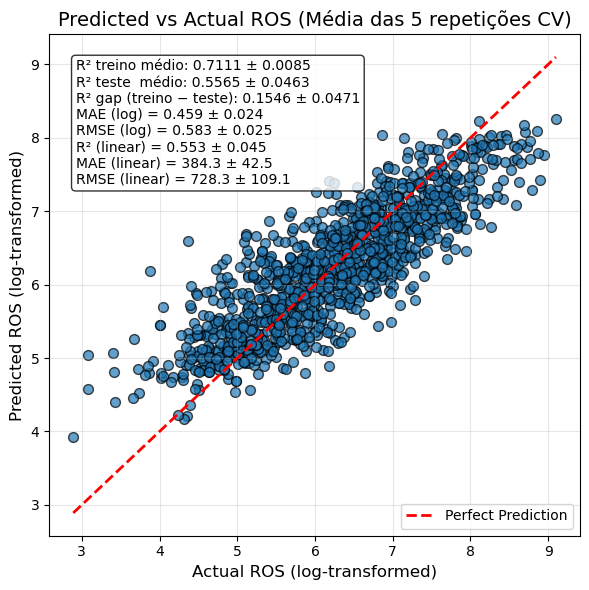

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# =============================
# Reuso de médias de previsões por amostra
# =============================
# avg_actual_log, avg_pred_log já calculados
y_actual_all = avg_actual_log
y_pred_all   = avg_pred_log

# =============================
# Função para reverter log seguro
# =============================
def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

y_actual_linear_all = inverse_safe_log(y_actual_all)
y_pred_linear_all   = inverse_safe_log(y_pred_all)

# =============================
# R², MAE e RMSE por fold (para ± std)
# =============================
r2_train_folds = []
r2_test_folds  = []
mae_folds      = []
rmse_folds     = []

for train_idx, test_idx in rkf.split(X_selected):
    X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
    y_train, y_test = y_selected.iloc[train_idx], y_selected.iloc[test_idx]

    y_pred_train = final_model_selected.predict(X_train)
    y_pred_test  = final_model_selected.predict(X_test)

    # Log fold metrics
    r2_train_folds.append(r2_score(y_train, y_pred_train))
    r2_test_folds.append(r2_score(y_test, y_pred_test))
    mae_folds.append(mean_absolute_error(y_test, y_pred_test))
    rmse_folds.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))

# Média ± std (log)
r2_train_cv_mean = np.mean(r2_train_folds)
r2_train_cv_std  = np.std(r2_train_folds)

r2_test_cv_mean  = np.mean(r2_test_folds)
r2_test_cv_std   = np.std(r2_test_folds)

r2_gap_cv_mean   = r2_train_cv_mean - r2_test_cv_mean
r2_gap_cv_std    = np.sqrt(r2_train_cv_std**2 + r2_test_cv_std**2)

mae_cv_mean = np.mean(mae_folds)
mae_cv_std  = np.std(mae_folds)
rmse_cv_mean = np.mean(rmse_folds)
rmse_cv_std  = np.std(rmse_folds)

# R², MAE, RMSE linear
r2_linear_folds = []
mae_linear_folds = []
rmse_linear_folds = []

for train_idx, test_idx in rkf.split(X_selected):
    X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
    y_train, y_test = y_selected.iloc[train_idx], y_selected.iloc[test_idx]

    y_pred_test = final_model_selected.predict(X_test)
    y_pred_linear_fold = inverse_safe_log(y_pred_test)
    y_test_linear_fold = inverse_safe_log(y_test)

    r2_linear_folds.append(r2_score(y_test_linear_fold, y_pred_linear_fold))
    mae_linear_folds.append(mean_absolute_error(y_test_linear_fold, y_pred_linear_fold))
    rmse_linear_folds.append(np.sqrt(mean_squared_error(y_test_linear_fold, y_pred_linear_fold)))

r2_linear_mean = np.mean(r2_linear_folds)
r2_linear_std  = np.std(r2_linear_folds)
mae_linear_mean = np.mean(mae_linear_folds)
mae_linear_std  = np.std(mae_linear_folds)
rmse_linear_mean = np.mean(rmse_linear_folds)
rmse_linear_std  = np.std(rmse_linear_folds)

# =============================
# Scatter Plot com ± std
# =============================
plt.figure(figsize=(6, 6))
plt.scatter(y_actual_all, y_pred_all, alpha=0.7, edgecolor='k', s=50)

min_val = min(y_actual_all.min(), y_pred_all.min())
max_val = max(y_actual_all.max(), y_pred_all.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Predicted vs Actual ROS (Média das 5 repetições CV)', fontsize=14)
plt.xlabel('Actual ROS (log-transformed)', fontsize=12)
plt.ylabel('Predicted ROS (log-transformed)', fontsize=12)

plt.text(
    0.05, 0.95,
    f"R² treino médio: {r2_train_cv:.4f} ± {r2_train_std:.4f}\n"
    f"R² teste  médio: {r2_test_cv:.4f} ± {r2_test_std:.4f}\n"
    f"R² gap (treino − teste): {r2_gap_cv:.4f} ± {r2_gap_std:.4f}\n"
    f'MAE (log) = {mae_cv_mean:.3f} ± {mae_cv_std:.3f}\n'
    f'RMSE (log) = {rmse_cv_mean:.3f} ± {rmse_cv_std:.3f}\n'
    f'R² (linear) = {r2_linear_mean:.3f} ± {r2_linear_std:.3f}\n'
    f'MAE (linear) = {mae_linear_mean:.1f} ± {mae_linear_std:.1f}\n'
    f'RMSE (linear) = {rmse_linear_mean:.1f} ± {rmse_linear_std:.1f}',
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


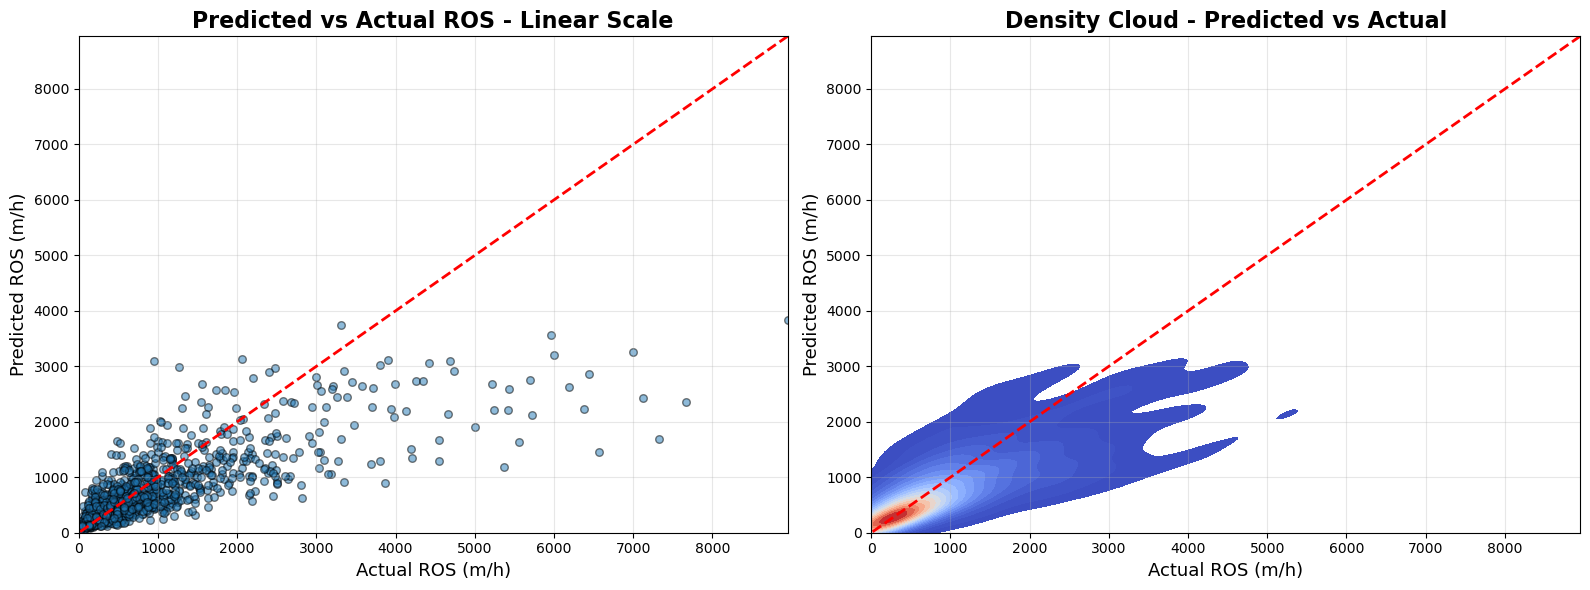

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# =============================
# Usar valores MÉDIOS já calculados no RepeatedKFold
# =============================
y_actual_log = avg_actual_log       # vindo da Parte 1
y_pred_log = avg_pred_log           # vindo da Parte 1

# Converter de log → linear
y_actual_linear = inverse_safe_log(y_actual_log)
y_pred_linear = inverse_safe_log(y_pred_log)

# =============================
# Métricas lineares
# =============================
rmse_linear_avg = np.sqrt(mean_squared_error(y_actual_linear, y_pred_linear))
mae_linear_avg = mean_absolute_error(y_actual_linear, y_pred_linear)
r2_linear = r2_score(y_actual_linear, y_pred_linear)

# =============================
# Plots: Scatter + 2D KDE
# =============================
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]}
)

# Limites uniformes para ambos os gráficos
min_val = min(y_actual_linear.min(), y_pred_linear.min())
max_val = max(y_actual_linear.max(), y_pred_linear.max())

# =============================
# Left panel: Scatter plot
# =============================
ax1.scatter(y_actual_linear, y_pred_linear, alpha=0.5, edgecolor='k', s=30)
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax1.set_title('Predicted vs Actual ROS - Linear Scale', fontsize=16, fontweight='bold')
ax1.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax1.set_ylabel('Predicted ROS (m/h)', fontsize=13)

ax1.set_xlim(0, max_val)
ax1.set_ylim(0, max_val)
ax1.grid(True, alpha=0.3)

# =============================
# Right panel: 2D KDE density plot
# =============================
sns.kdeplot(
    x=y_actual_linear, y=y_pred_linear,
    ax=ax2, fill=True, cmap="coolwarm",
    levels=20, thresh=0.04
)

ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

ax2.set_title('Density Cloud - Predicted vs Actual', fontsize=16, fontweight='bold')
ax2.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax2.set_ylabel('Predicted ROS (m/h)', fontsize=13)

ax2.set_xlim(0, max_val)
ax2.set_ylim(0, max_val)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


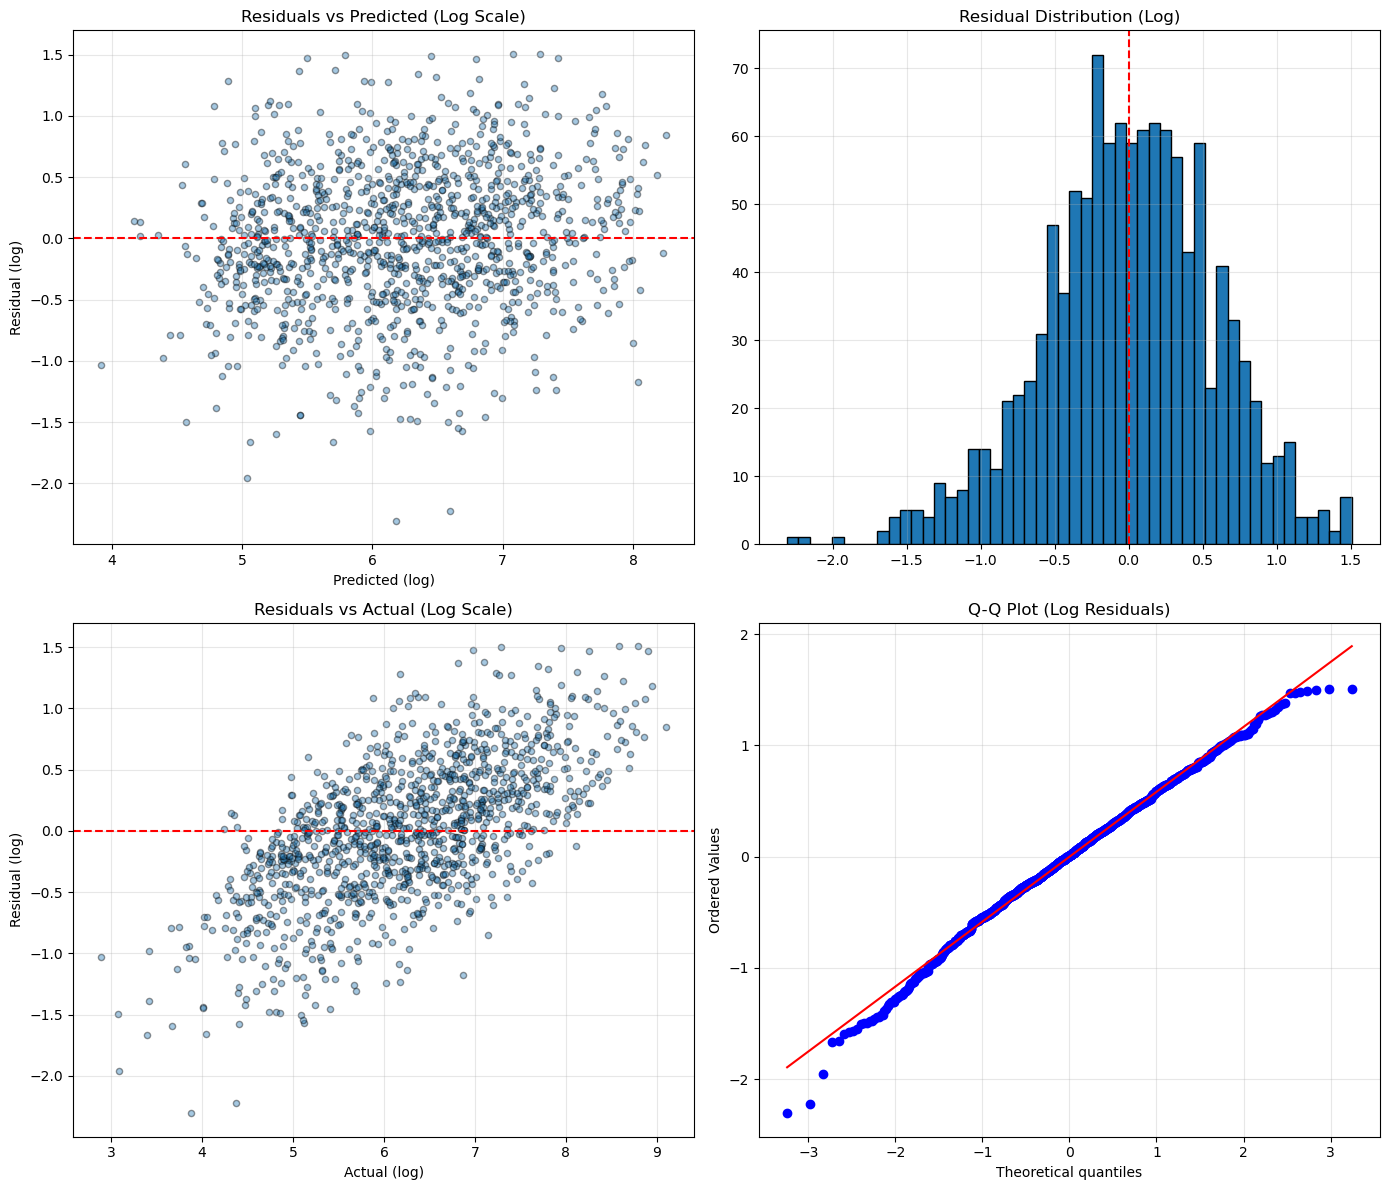

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# =============================
# Usar diretamente as MÉDIAS do RepeatedKFold
# =============================
avg_actual = avg_actual_log      # valores reais médios (log)
avg_pred   = avg_pred_log        # valores previstos médios (log)

# Conversão para escala linear (se quiser usar depois)
avg_actual_linear = inverse_safe_log(avg_actual)
avg_pred_linear   = inverse_safe_log(avg_pred)

# Resíduos em escala log
residuals_log = avg_actual - avg_pred

# =============================
# RESIDUAL PLOTS
# =============================
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# 1 — Residuals vs Predicted
ax[0,0].scatter(avg_pred, residuals_log, alpha=0.4, s=20, edgecolor="k")
ax[0,0].axhline(0, color="r", linestyle="--")
ax[0,0].set_title("Residuals vs Predicted (Log Scale)")
ax[0,0].set_xlabel("Predicted (log)")
ax[0,0].set_ylabel("Residual (log)")
ax[0,0].grid(True, alpha=0.3)

# 2 — Histogram of residuals
ax[0,1].hist(residuals_log, bins=50, edgecolor='k')
ax[0,1].axvline(0, color="r", linestyle="--")
ax[0,1].set_title("Residual Distribution (Log)")
ax[0,1].grid(True, alpha=0.3)

# 3 — Residuals vs Actual
ax[1,0].scatter(avg_actual, residuals_log, alpha=0.4, s=20, edgecolor="k")
ax[1,0].axhline(0, color="r", linestyle="--")
ax[1,0].set_title("Residuals vs Actual (Log Scale)")
ax[1,0].set_xlabel("Actual (log)")
ax[1,0].set_ylabel("Residual (log)")
ax[1,0].grid(True, alpha=0.3)

# 4 — Q-Q Plot
stats.probplot(residuals_log, dist="norm", plot=ax[1,1])
ax[1,1].set_title("Q-Q Plot (Log Residuals)")
ax[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


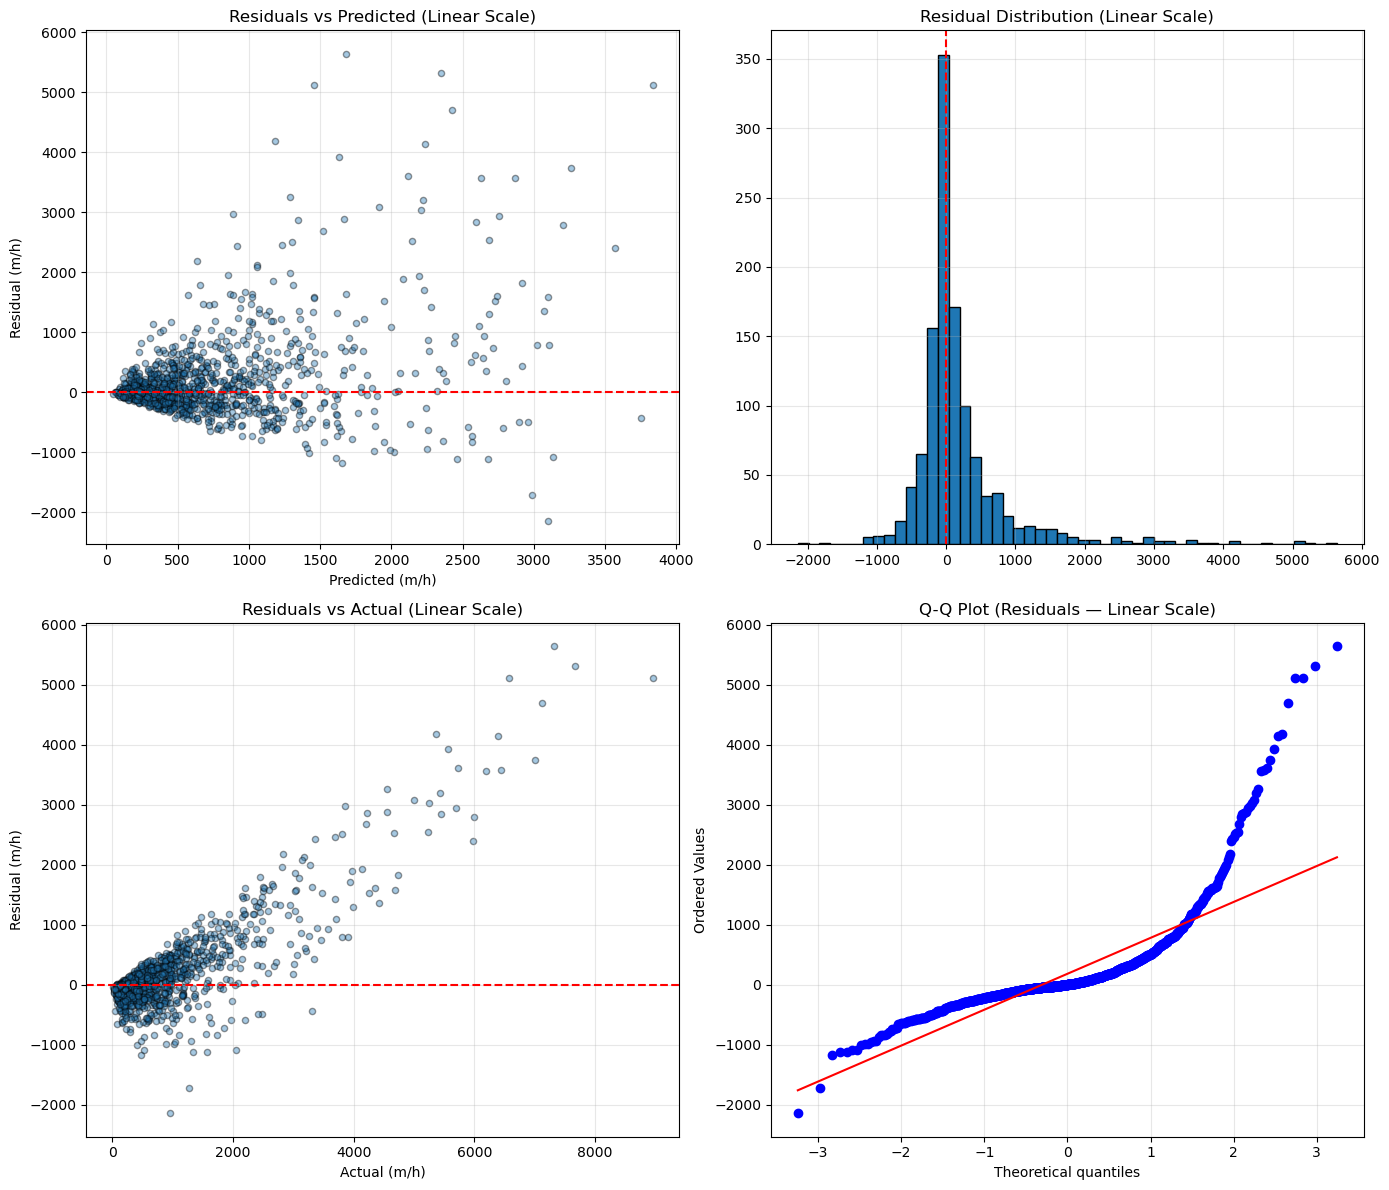

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# =============================
# Valores médios em escala log
# =============================
avg_actual_log = avg_actual_log      # já calculado antes
avg_pred_log   = avg_pred_log        # já calculado antes

# =============================
# Converter para escala linear
# =============================
avg_actual_linear = inverse_safe_log(avg_actual_log)
avg_pred_linear   = inverse_safe_log(avg_pred_log)

# =============================
# Resíduos em escala linear
# =============================
residuals_linear = avg_actual_linear - avg_pred_linear

# =============================
# RESIDUAL PLOTS — LINEAR SCALE
# =============================
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# 1 — Residuals vs Predicted
ax[0,0].scatter(avg_pred_linear, residuals_linear, alpha=0.4, s=20, edgecolor="k")
ax[0,0].axhline(0, color="r", linestyle="--")
ax[0,0].set_title("Residuals vs Predicted (Linear Scale)")
ax[0,0].set_xlabel("Predicted (m/h)")
ax[0,0].set_ylabel("Residual (m/h)")
ax[0,0].grid(True, alpha=0.3)

# 2 — Histogram
ax[0,1].hist(residuals_linear, bins=50, edgecolor='k')
ax[0,1].axvline(0, color="r", linestyle="--")
ax[0,1].set_title("Residual Distribution (Linear Scale)")
ax[0,1].grid(True, alpha=0.3)

# 3 — Residuals vs Actual
ax[1,0].scatter(avg_actual_linear, residuals_linear, alpha=0.4, s=20, edgecolor="k")
ax[1,0].axhline(0, color="r", linestyle="--")
ax[1,0].set_title("Residuals vs Actual (Linear Scale)")
ax[1,0].set_xlabel("Actual (m/h)")
ax[1,0].set_ylabel("Residual (m/h)")
ax[1,0].grid(True, alpha=0.3)

# 4 — Q-Q plot
stats.probplot(residuals_linear, dist="norm", plot=ax[1,1])
ax[1,1].set_title("Q-Q Plot (Residuals — Linear Scale)")
ax[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Prediction Quality Summary (Threshold = ±35.0%):
---------------------------------------------------------
Good Predictions : 571  (48.7%)
Bad Predictions  : 602  (51.3%)


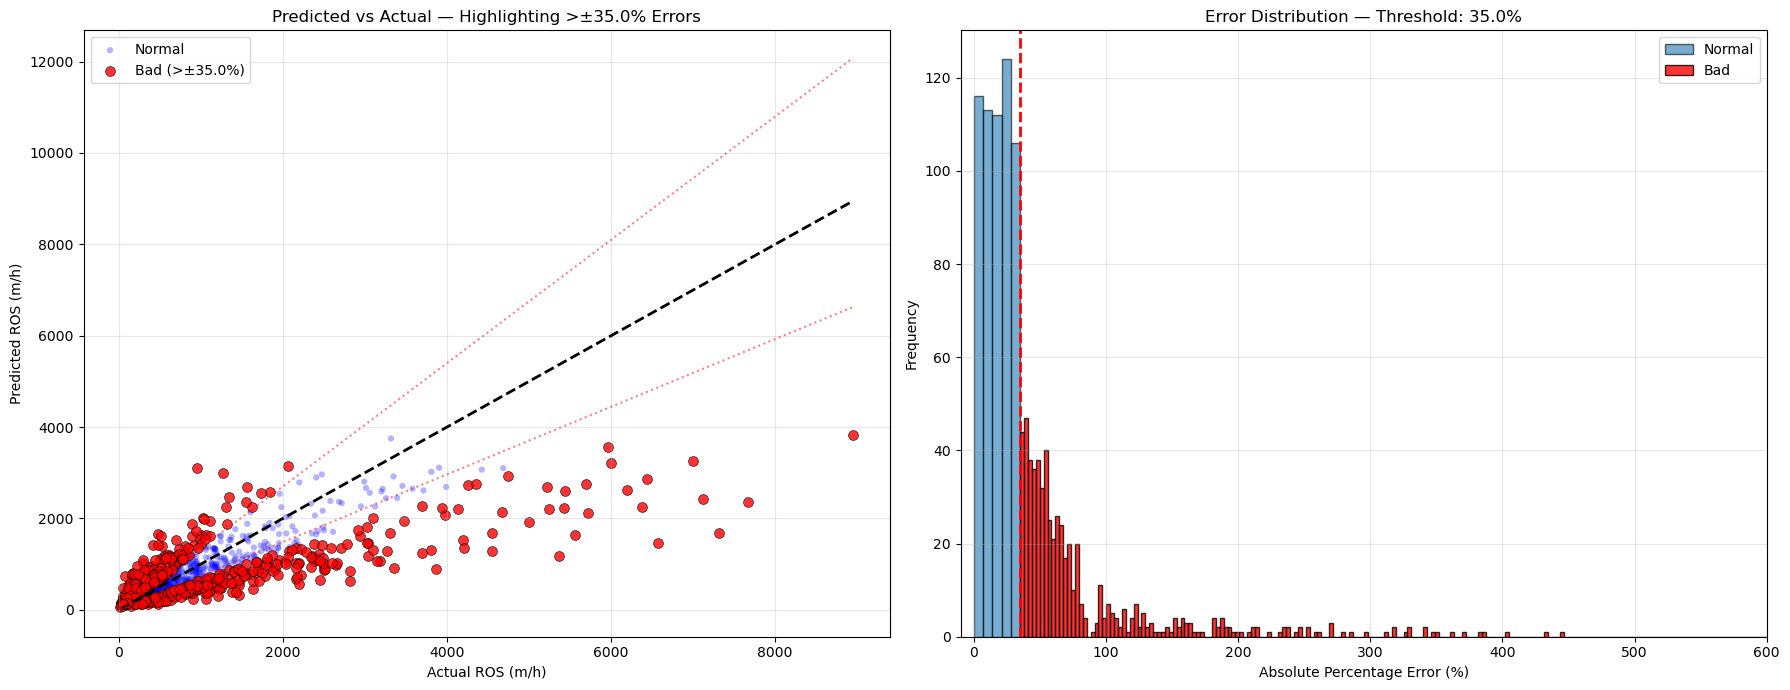

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# =============================
# Configurações
# =============================
threshold = 35.0

# Residuals lineares
residuals = avg_pred_linear - avg_actual_linear

# Percentual de erro
with np.errstate(divide='ignore', invalid='ignore'):
    percent_errors_signed = np.where(
        avg_actual_linear != 0,
        (residuals / avg_actual_linear) * 100,
        0
    )
percent_errors = np.abs(percent_errors_signed)

# Máscara de "bad predictions"
bad_pred_mask = percent_errors > threshold

# =============================
# Estatísticas
# =============================
n_total = len(bad_pred_mask)
n_bad   = bad_pred_mask.sum()
n_good  = n_total - n_bad

pct_bad  = (n_bad / n_total) * 100
pct_good = (n_good / n_total) * 100

print(f"\nPrediction Quality Summary (Threshold = ±{threshold}%):")
print("---------------------------------------------------------")
print(f"Good Predictions : {n_good}  ({pct_good:.1f}%)")
print(f"Bad Predictions  : {n_bad}  ({pct_bad:.1f}%)")

# =============================
# PLOT 1 — SCATTER ACTUAL vs PREDICTED
# =============================
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Normal predictions
ax[0].scatter(
    avg_actual_linear[~bad_pred_mask],
    avg_pred_linear[~bad_pred_mask],
    alpha=0.3, s=20, c='blue', edgecolor='none', label='Normal'
)

# Bad predictions
ax[0].scatter(
    avg_actual_linear[bad_pred_mask],
    avg_pred_linear[bad_pred_mask],
    alpha=0.8, s=50, c='red', edgecolor='black', linewidth=0.5,
    label=f'Bad (>±{threshold}%)'
)

# Linha de previsão perfeita
min_val = min(avg_actual_linear.min(), avg_pred_linear.min())
max_val = max(avg_actual_linear.max(), avg_pred_linear.max())
ax[0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2)

# Faixas do threshold
x_range = np.linspace(min_val, max_val, 100)
factor = 1 + threshold/100
ax[0].plot(x_range, x_range * factor, 'r:', linewidth=1.5, alpha=0.5)
ax[0].plot(x_range, x_range / factor, 'r:', linewidth=1.5, alpha=0.5)

ax[0].set_xlabel("Actual ROS (m/h)")
ax[0].set_ylabel("Predicted ROS (m/h)")
ax[0].set_title(f"Predicted vs Actual — Highlighting >±{threshold}% Errors")
ax[0].grid(True, alpha=0.3)
ax[0].legend()

# =============================
# PLOT 2 — HISTOGRAM ERROR DISTRIBUTION
# =============================
ax[1].hist(percent_errors[~bad_pred_mask], bins=5, alpha=0.6, edgecolor='black', label='Normal')
ax[1].hist(percent_errors[bad_pred_mask], bins=300, alpha=0.8, color='red', edgecolor='black', label='Bad')

ax[1].axvline(x=threshold, color='red', linestyle='--', linewidth=2)

ax[1].set_xlabel("Absolute Percentage Error (%)")
ax[1].set_ylabel("Frequency")
ax[1].set_xlim(-10, 600)
ax[1].set_title(f"Error Distribution — Threshold: {threshold}%")
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.tight_layout()
plt.show()
